<center> Scalable K-means++</center>
 ====
<center> Bai Li, Jialiang Mao </center>
----

Abstract
----
K-means algorithm is one of the most popular clustering algorithm. A crucial part of k-means algorithm is the choice of initial centers while a poor initial centers may lead to locally optimal solution. To beat this, the k-means++ initialization is proposed to obtain an initial set of centers that is close to the global optimum solution. However, because of its sequential nature, the k-means++ is not scalable. The paper introduces a scalable k-means++ algorithm by reducing the number of passes needed to obtain a good initialization. 


1. Outline
----

In this project, we implement this algorithm and test its performance with simulation studies. We also try multiple ways to improve its performace including Cython, vectorization and finally parallelization.

The outline of our project is listed:
  * Implement the basic version of k-means algorithm
  * Implement k-means++ and scalable k-means initialization based on basic k-means.
  * Simulate data that come from prespecified clusters and test our algorithms for both correctness and efficiency.
  * Speed up the algorithms with Cython. We implement the most ineffcient part (mostly for loops) with Cython and test its performance.
  * Speed up the algorithms by removing for loops. We remove for loops to improve the efficiency.

2. Implementation
----

In this section, we implement basic k-means, k-means++ and scalable k-means++. Note we also leave interfaces for cython so we can improve the performance later. 

Firstly, we implement the basic k-means algorithm, which is the foundation of other k-means algorithms. To begin with, we define some measures that appear in the k-means algorithm.

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.linalg as la
import time
import random
from random import randint
%matplotlib inline
%precision 5
plt.style.use('ggplot')
import numpy.random as rng

In [2]:
def squared_euclidean_norm(u, axis=-1):
    """
    Calculate the squared Euclidean norm.
    """
    return((u**2).sum(axis))

def euclidean_norm(u, axis=-1):
    """
    Calculate the Euclidean norm.
    """
    return np.sqrt(squared_euclidean_norm(u, axis))

def squared_euclidean_dist(u, v, axis=-1):
    """
    Calculate squared Euclidean distance between two vectors.
    """
    return squared_euclidean_norm(u-v, axis)

def min_squared_euclidean_dist(u, v, axis=-1):
    """
    Calculate the minimum of Euclidean distance between a list of vectors and a vector v.
    """
    distMin = squared_euclidean_dist(u[0],v)
    for i in range(0,len(u)):
        distMin = np.minimum(squared_euclidean_dist(u[i],v),distMin)
    return distMin

def euclidean_dist(u, v, axis=-1):
    """
    Calculate Euclidean distacne between two vectors.
    """
    return np.sqrt(squared_euclidean_dist(u, v, axis))

Next, we define the function to implement the k-means algorithm. Here we also create an interface to allow future speed-up with Cython.

In [3]:
def kMeans(k,df, initial,embedded = False, speedUp =False):
    """
    Implement the basic version of k-means algorithm.
    
    Parameters
    ----------
    k : the number of clusters
    
    df : the data we apply k-means to
    
    initial : the initial guess for the centroids
    
    embedded : logic value, if it is True, we use initial as start points, 
    otherwise, use random samples from the data
    
    speedUp : logic value, it it is True, we run loops with Cython
    
    Returns
    ----------
    newCentroid: the final centroids for each cluster
    
    clusterNo1: indicate data belong to which cluster
    """
    newCentroid = initial
    if(embedded) :
        pass
    else:
        newCentroid = df[np.random.choice(range(df.shape[0]),k), :]   
    tmp1, tmp2 = 0,0
    clusterNo1,clusterNo2 = np.ones(len(df)),np.zeros(len(df))
    while(np.array_equal(clusterNo1,clusterNo2)==False) : 
        clusterNo2=clusterNo1.copy()
        for i in range(0,len(df)):
            tmp1 = tmp1 + 1
            if(speedUp==True):
                distance = euclidean_dist_cython(newCentroid,df[i])
            else:
                distance = euclidean_dist(newCentroid,df[i]) 
            clusterNo1[i] = min(np.asarray(np.where(distance[:]==min(distance))))[0]
        for j in range(0,k):
            newCentroid[j] = np.mean(df[np.where(clusterNo1[:]==j)][:,0:len(df[0])], axis=0)
        tmp2 = tmp2 + 1
    return newCentroid,clusterNo1

With the algorithm that implement the basic k-means algorithm, we can now define the k-means++ algorithm. Instead of randomly select initial cluster centers, we only select the first initial cluser center randomly and choose other initial centers in a sequential way. Specifically, given current initial centers, we choose the next initial center so that its far from current centers.

In [4]:
def kMeansPlusPlus(k,df,speedUp = False):
    """
    Perform k-means++ algorithm to obtain optimized initial guess for the centroids.
    
    Parameters
    ----------
    k : the number of clusters
    
    df : the data we apply k-means to
    
    speedUp : logic value, it it is True, we run loops with Cython
    
    Returns
    ----------
    newCentroid: the final centroids for each cluster
    
    clusterNo1: indicate data belong to which cluster
    """
    center = []
    center.append(df[randint(0,len(df))])
    phi = squared_euclidean_dist(center[0],df)
    px = phi/sum(phi)
    cluster2 = []
    while len(center) < k:
        sample = np.random.multinomial(1,px).tolist()
        center.append(df[sample.index(max(sample))])
        phi = min_squared_euclidean_dist(center,df)
        px = phi/sum(phi)
    return kMeans(k,df,np.array(center),True,speedUp)

The k-means++ algorithm gives a way to systematically select a collection of initial cluster centers. However, the sequential nature behind this initialization makes it hard for us to run this algoriehm in parallel. Therefore, we then implement the scalable k-means++ algorithm, which could be viewed as a combination of the basic random initialization and the sequential initialization.

In [5]:
def scalableKMeans(k,l,df,speedUp=False):
    """
    Perform scalable k-means algorithm to obtain optimized initial guess for the centroids.
    
    Parameters
    ----------
    k : the number of clusters
    
    l : oversample factor
    
    df : the data we apply k-means to
    
    speedUp : logic value, it it is True, we run loops with Cython
    
    Returns
    ----------
    newCentroid: the final centroids for each cluster
    
    clusterNo1: indicate data belong to which cluster
    """
    center = []
    center.append(df[randint(0,len(df))])
    phi = squared_euclidean_dist(center[0],df)
    px = (l*phi) / sum(phi) 
    for i in range(0,int(np.log(sum(phi)))):
        uArray = np.random.uniform(0,1,len(df))
        for j in range(0,len(df)):
            if uArray[j] < px[j]:
                center.append(df[j])    
            phi = min_squared_euclidean_dist(center,df) 
            px = l*phi/sum(phi)
    omega = np.zeros(len(center))
    if(speedUp==True):
        centerArray = np.asarray(center)
        for i in range(0,len(df)):
            sample = euclidean_dist_cython(centerArray,df[i]).tolist()
            position = sample.index(min(sample))
            omega[position] = omega[position] + 1
    if(speedUp==False):
        for i in range(0,len(df)):
            sample = euclidean_dist(center,df[i]).tolist()
            position = sample.index(min(sample))
            omega[position] = omega[position] + 1
    omegaProb = omega/sum(omega)
    center2 = []
    while len(center2) < k:
        sample = np.random.multinomial(1,omegaProb).tolist()
        position1 = sample.index(max(sample))
        center2.append(center[position1])
        phi = min_squared_euclidean_dist(center2,center)
        px = phi/sum(phi)
    return kMeans(k,df,np.asarray(center2),True,speedUp)

3. Testing
----

Firstly, we need to test that our impletations actually work. Here we consider two simulation cases. 

### Example 1.

In the first case, we consider data in $R^3$. We pre-define five clusters and generate 100 data in each cluster.  

In [6]:
def simulation1(n):
    """ 
    Generate data that come from 5 clusters whose centroids are specified.
    
    Parameters
    ----------
    n: number of data we want to obtain from each cluster
    """
    mean = np.array([[10,10,10],[10,0,0],[0,10,0],[0,0,10],[0, 0, 0]])
    data=np.random.multivariate_normal(mean[0,], np.eye(3), n)
    data=np.hstack((data, np.zeros((data.shape[0],1))))
    for i in [1,2,3,4]:
        dataTmp=np.random.multivariate_normal(mean[i,], np.eye(3), n)
        data=np.vstack((data,np.hstack((dataTmp, np.ones((dataTmp.shape[0],1))*i))))
        np.random.shuffle(data)
    observation = data [:,0:3]
    clusterNumber = data [:,3]
    return observation,clusterNumber

In [7]:
rng.seed(144)
X,y = simulation1(100)
initial = np.array([X[1],X[2],X[3],X[2],X[1]])

In [8]:
rng.seed(144)
random.seed(144)
centers,index = kMeans(5,X,initial)
centers

array([[  9.97565e+00,   1.60241e-02,  -1.93955e-01],
       [  4.74776e-02,   9.97001e+00,   2.88649e-01],
       [ -7.44783e-03,  -1.91555e-01,  -2.28108e-02],
       [ -5.50655e-02,  -5.86116e-02,   1.00713e+01],
       [  1.00131e+01,   9.92592e+00,   1.00322e+01]])

In [9]:
rng.seed(144)
random.seed(144)
centers,index = kMeansPlusPlus(5,X)
centers

array([[ -7.44783e-03,  -1.91555e-01,  -2.28108e-02],
       [  1.00131e+01,   9.92592e+00,   1.00322e+01],
       [  9.97565e+00,   1.60241e-02,  -1.93955e-01],
       [ -5.50655e-02,  -5.86116e-02,   1.00713e+01],
       [  4.74776e-02,   9.97001e+00,   2.88649e-01]])

In [10]:
rng.seed(144)
random.seed(144)
centers,index = scalableKMeans(5,2,X)
centers

array([[  4.74776e-02,   9.97001e+00,   2.88649e-01],
       [ -7.44783e-03,  -1.91555e-01,  -2.28108e-02],
       [ -5.50655e-02,  -5.86116e-02,   1.00713e+01],
       [  1.00131e+01,   9.92592e+00,   1.00322e+01],
       [  9.97565e+00,   1.60241e-02,  -1.93955e-01]])

We can see that the basic k-means algorithm, the k-means++ algorithm and the scalable k-means++ algorithm actually work (they converge to similar centers).

In [11]:
%%time
rng.seed(144)
random.seed(144)
centers,index = kMeans(5,X,initial)

CPU times: user 35.3 ms, sys: 6.52 ms, total: 41.8 ms
Wall time: 36.5 ms


In [12]:
%%time
rng.seed(144)
random.seed(144)
centers,index = kMeansPlusPlus(5,X)

CPU times: user 21.6 ms, sys: 2.68 ms, total: 24.3 ms
Wall time: 22 ms


In [13]:
%%time
rng.seed(144)
random.seed(144)
centers,index = scalableKMeans(5,2,X)

CPU times: user 1.41 s, sys: 1.28 ms, total: 1.41 s
Wall time: 1.41 s


Actually, in this simple simulation case, the non-parallelized scalable k-means++ algorithm is much slower than the other two algorithms. Since the number of our data points is limited, the basic algorithm could converge really fast and the sequential initialization does not take long.

### Example 2.

There is a more important reason to 'force' us to use the k-means++ algorithm and the scalable version of it. The k-means algorithm may fail to identify correct clusters due to some specific initializations, which can be illustrated in the following figures: 

![](k_Means_initial.PNG)

With this setting of clusters and initial guesses, the k-means algorithm may give the following results:

![](k_Means.PNG)

We also use simulated data to illustrate that this will actually happen. We pre-define four clusters and generate 100 data in each cluster. 

In [14]:
def simulation2(n):
    """ 
    Generate data that come from 3 clusters whose centroids are specified.
    
    Parameters
    ----------
    n: number of data we want to obtain from each cluster
    """
    mean = np.array([[-5,-5],[-5,5],[5,-2],[5,3]])
    data=np.random.multivariate_normal(mean[0,], np.eye(2), n)
    data=np.hstack((data, np.zeros((data.shape[0],1))))
    for i in [1,2,3]:
        dataTmp=np.random.multivariate_normal(mean[i,], np.eye(2), n)
        data=np.vstack((data,np.hstack((dataTmp, np.ones((dataTmp.shape[0],1))*i))))
        np.random.shuffle(data)
    observation = data [:,0:2]
    clusterNumber = data [:,2]
    return observation,clusterNumber

In [15]:
rng.seed(144)
X2,y2 = simulation2(100)
initial2 = np.array([X2[1],X2[2],X2[2],X2[1]])

We could also plot the raw data.

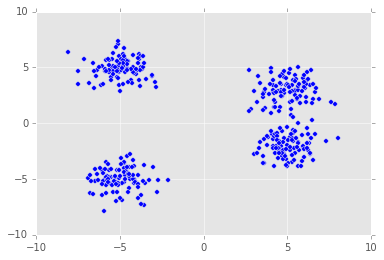

In [16]:
for i in range (3):
    plt.scatter(X2[:,0], X2[:,1])

Next, we apply all the three algorithms on this dataset and evaluate their performance.
Basic k-means
--------

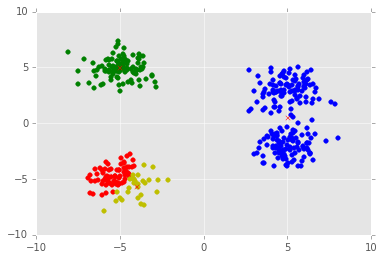

In [17]:
rng.seed(14)
random.seed(14)
centers,index = kMeans(4,X2,initial2)
cols=iter(['r','y','g','b'])
for i in range (4):
    plt.scatter(X2[index == i][:,0], X2[index == i, :][:,1], color=next(cols))
plt.scatter(centers[:,0], centers[:,1], color='r', marker='x')

k-means++
--------

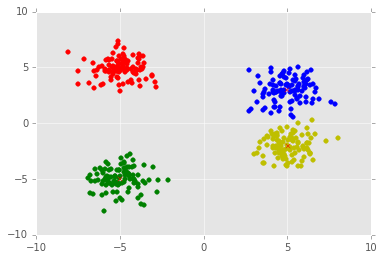

In [18]:
rng.seed(14)
random.seed(14)
centers,index = kMeansPlusPlus(4,X2)
cols=iter(['r','y','g','b'])
for i in range (4):
    plt.scatter(X2[index == i][:,0], X2[index == i, :][:,1], color=next(cols))
plt.scatter(centers[:,0], centers[:,1], color='r', marker='x')

Scalable k-means++:
--

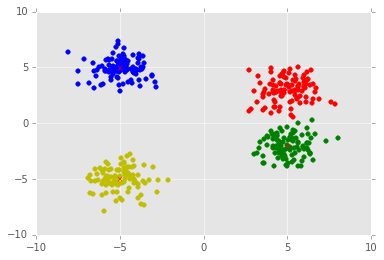

In [19]:
rng.seed(14)
random.seed(14)
centers,index = scalableKMeans(4,2,X2)
cols=iter(['r','y','g','b'])
for i in range (4):
    plt.scatter(X2[index == i][:,0], X2[index == i, :][:,1], color=next(cols))
plt.scatter(centers[:,0], centers[:,1], color='r', marker='x')

Based on this simulation case, the basic k-means algorithm sometimes gives us unreasonable results. This is because the random initialization, which may not be optimal in many cases. The other two algorithms, on the other hand, choose the initial cluster centers in a systematic way. Therefore, the clustering results are always reasonable.

4. Speeding up the code with Cython and removing forloops 
----

### 4.1. Speeding up with Cython

In this section, we try to optimize our code with Cython. Notice that there are several for-loops in our implementation, we could write some of these loops with Cython to make them faster. Some of the functions that slow down our program are the functions that compute the distance among points. In the basic k-means, the bottleneck is the for-loop for calculating the minimum distance between data and centroids, which is the only part that takes $O(n^2)$ time. We re-write these functions in Cython.

In [20]:
%load_ext cython

In [21]:
%%cython -a
from libc.math cimport sqrt
import numpy as np
import cython
cimport numpy as np
cimport cython

DTYPE = np.float64
ctypedef np.float64_t DTYPE_t
@cython.boundscheck(False)  
@cython.nonecheck(False)

def euclidean_dist_cython(np.ndarray[DTYPE_t, ndim=2] data, np.ndarray[DTYPE_t, ndim=1] position):
    """
    Calculate the squared Euclidean norm with Cython
    """
    cdef unsigned int i
    cdef unsigned int j = data.shape[0]
    cdef np.ndarray[DTYPE_t, ndim=1] distance = np.zeros(j)
    for i in xrange(0,j):
        distance[i] = sqrt((data[i,0] - position[0])**2 + (data[i,1] - position[1])**2 + (data[i,2] - position[2])**2)
    return distance


def euclidean_squared_dist_cython(np.ndarray[DTYPE_t, ndim=2] data, np.ndarray[DTYPE_t, ndim=1] position):
    """
    Calculate squared Euclidean distance between two vectors with Cython
    """
    cdef unsigned int i
    cdef unsigned int j = data.shape[0]
    cdef np.ndarray[DTYPE_t, ndim=1] distance = np.zeros(j)
    for i in xrange(0,j):
        distance[i] = ((data[i,0] - position[0])**2 + (data[i,1] - position[1])**2 + (data[i,2] - position[2])**2)
    return distance


def min_euclidean_dist_cython(u, v, axis=-1):
    """
    Calculate the minimum of Euclidean distance between a list of vectors and a vector v with Cython
    """ 
    distMin = euclidean_dist_cython(u[0],v)
    for i in range(0,len(u)):
        distMin = np.minimum(euclidean_dist_cython(u[i],v),distMin)
    return distMin


def minimum_distance(np.ndarray[np.float64_t, ndim=1] data, np.ndarray[np.float64_t, ndim=2] centers):
    """
    Calculate Euclidean distacne between two vectors with Cython
    """
    cdef int minIndex = 0
    cdef float minDistance = 1000000
    cdef int i
    cdef np.ndarray[np.float64_t, ndim=1] j
    for i, j in enumerate(centers):
        distance = np.sum((data - j) ** 2)
        if minDistance > distance:
            minDistance = distance
            minIndex = i
    return minDistance,minIndex

Next we run our implementation with/without Cython on our example 1. 

In [22]:
%%time
rng.seed(144)
random.seed(144)
centers,index = kMeans(5,X,initial)
###---Basic K-means without Cython---###

CPU times: user 32.6 ms, sys: 5.85 ms, total: 38.5 ms
Wall time: 33.9 ms


In [23]:
%%time
rng.seed(144)
random.seed(144)
centers,index = kMeans(5,X,initial, speedUp=True)
###---Basic K-means with Cython---###

CPU times: user 22.4 ms, sys: 5.58 ms, total: 28 ms
Wall time: 23.4 ms


In [24]:
%%time
rng.seed(144)
random.seed(144)
centers,index = kMeansPlusPlus(5,X)
###---K-means++ without Cython---###

CPU times: user 20.1 ms, sys: 516 µs, total: 20.6 ms
Wall time: 20.1 ms


In [25]:
%%time
rng.seed(144)
random.seed(144)
centers,index = kMeansPlusPlus(5,X, speedUp=True)
###---K-means++ with Cython---###

CPU times: user 15.3 ms, sys: 2.29 ms, total: 17.6 ms
Wall time: 15.6 ms


In [26]:
%%time
rng.seed(144)
random.seed(144)
centers,index = scalableKMeans(5,2,X)
###---scalable K-means++ without Cython---###

CPU times: user 1.41 s, sys: 1.74 ms, total: 1.41 s
Wall time: 1.41 s


In [27]:
%%time
rng.seed(144)
random.seed(144)
centers,index = scalableKMeans(5,2,X, speedUp=True)
###---scalable K-means++ with Cython---###

CPU times: user 1.5 s, sys: 2.5 ms, total: 1.51 s
Wall time: 1.51 s


We can see that our Cython implementation improves the basic k-means significantly. However, it only improve the other two algorithms slightly. This is because our Cython version only optimizes the steps after initialization. But one of the bottlenecks of the other two algorithms are the initialization part (contains random sampling, etc.). Therefore, we need other optimization methods (or write the initialization part also in Cython).

### 4.2. Speeding up by removing forloops

In [28]:
from numba import jit

In [29]:
@jit
def kMeansFast(k,df, centroids,embedded = False):
    """
    Implement the basic version of k-means algorithm faster.
    
    Parameters
    ----------
    k : the number of clusters
    
    df : the data we apply k-means to
    
    centroids : the initial guess for the centroids
    
    embedded : logic value, if it is True, we use initial as start points, 
    otherwise, use random samples from the data
    
    Returns
    ----------
    newCentroid: the final centroids for each cluster
    
    clusterNo1: indicate data belong to which cluster
    """
    if not embedded:
        centroids = df[np.random.choice(range(df.shape[0]),k), :]
    extraData = df[:, np.newaxis, :]
    newCentroids = np.empty(centroids.shape)
    distances = np.sum((extraData -centroids)**2, axis=2)
    minLocation1 = np.zeros(distances.shape)
    minLocation2 = np.ones(distances.shape)
    tmp1 = 0
    while not np.array_equal(minLocation2,minLocation1) :
        minLocation2 = minLocation1.copy()
        distances = np.sum((extraData -centroids)**2, axis=2)
        minLocation1 = np.zeros(distances.shape)
        minLocation1[range(distances.shape[0]), np.argmin(distances, axis=1)] = 1
        for i in range(0, k):
            newCentroids[i] = np.mean(df[minLocation1[:, i] == True, :], axis=0)
        tmp1 = tmp1 + 1
        centroids = newCentroids.copy()
    return newCentroids,tmp1

In [30]:
def kMeansPlusPlusFast(k,df):
    """
    Implement the k-means++ algorithm faster.
    
    Parameters
    ----------
    k : the number of clusters
    
    df : the data we apply k-means to

    Returns
    ----------
    newCentroid: the final centroids for each cluster
    
    clusterNo1: indicate data belong to which cluster
    """
    centroids = df[np.random.choice(range(df.shape[0]),1), :]
    while len(centroids) < k:
        distances = np.sum((df[:, np.newaxis, :] - centroids) ** 2, axis=2)
        minLocation1 = np.zeros(distances.shape)
        minLocation1[range(distances.shape[0]), np.argmin(distances, axis=1)] = 1
        distribution = np.min(distances, axis=1)/np.sum(distances[minLocation1 == True])
        centroids = np.vstack([centroids, df[np.random.choice(range(df.shape[0]),1, p = distribution),:]])
    return kMeansFast(k,df,centroids,True)

In [31]:
%%time
res=kMeansFast(5,X,initial2)

CPU times: user 806 ms, sys: 12.7 ms, total: 819 ms
Wall time: 818 ms


In [32]:
%%time
res=kMeansPlusPlusFast(5,X)

CPU times: user 4.08 ms, sys: 592 µs, total: 4.67 ms
Wall time: 4.08 ms


# 5. Discussion

Based on our analysis, all the three k-means algorithms work. The basic version will fail when the random initialization is poor while the improved k-means algorithms could solve this problem. In terms of speed, the basic k-means is quit fast when the data points are not too many. Because of the complicated initialization scheme, the unparallelized scalable k-means++ is slower than the simpler version. Future works will include writing the scalable k-means++ algorithm in parallel. 